
```
Copyright (C) 2019 Software Platform Lab, Seoul National University

Licensed under the Apache License, Version 2.0 (the "License"); 

you may not use this file except in compliance with the License. 

You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software 

distributed under the License is distributed on an "AS IS" BASIS, 


WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. 


See the License for the specific language governing permissions and


limitations under the License.
```

# Deep Reinforcement Learning (DRL)

In this practice session, we will learn how to build a Deep Reinforcement Learning algorithm using TensorFlow. Most of the content is re-constructed from a great blog article [Deep Reinforcement Learning: Playing CartPole through Asynchronous Advantage Actor Critic (A3C) with tf.keras and eager execution](https://medium.com/tensorflow/deep-reinforcement-learning-playing-cartpole-through-asynchronous-advantage-actor-critic-a3c-7eab2eea5296) written by Raymond Yuan, a former Software Engineering Intern at Google. As mentioend earlier, we will use high-level APIs (Keras and Eager execution) that we learned last time, which allows us to build RL models much easier.

** \*\*NOTE\*\* ** As an important reminder, since we will use Eager execution, let's not forget to enable eager execution at the beginning. Otherwise, you will encounter an error when we run the algorithms then you should restart the runtime and re-run all cells.

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

print(tf.executing_eagerly()) # Should be True

True




## 1. Introduction to DRL

Reinforcement learning (RL) is a task to learn how to decide the sequence of *actions* in an uncertain *environment* to achieve some goals (e.g., play a video game and achieve the maximum score). RL has been widely used in many tasks (e.g., video game, robotics, self-driving car) that require sequential decision-making.
Similar to many other fields, Deep learning also plays an important role to improve the performance of RL; DRL, a combination of deep learning and reinforcement learning, has been successful in solving complex tasks with lower prior knowledge thanks to its capability to learn different levels of abstractions from data.

## 2. CartPole Game

### 2-1. What is CartPole?
Among many DRL applications, we will implement CartPole in this session. Cartpole is a game in which a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The starting state (cart position, cart velocity, pole angle, and pole velocity at tip) is randomly initialized between +/-0.05. The system is controlled by applying a force of +1 or -1 to the cart (moving left or right). The pendulum starts upright, and the goal is to prevent it from falling over. A *reward* of +1 is provided for every timestep that the pole remains upright. The *episode* ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

The blog post [Introduction to Reinforcement Learning](https://medium.com/@curiousily/getting-your-feet-rewarded-deep-reinforcement-learning-for-hackers-part-0-900ca5bb83e5) (by Venelin Valkov) provides a nice representation and summary of the concepts in CartPole game, as shown below:

![cart pole game](https://cdn-images-1.medium.com/max/800/1*2OydMu71FKg3MCVF39T4Xg.png)  

* Goal :  Balance the pole on top of a moving cart
* States:  angle, angular speed, position, horizontal velocity
* Actions:  horizontal force to the cart
* Reward : 1 at each time step if the pole is upright



### 2-2. How does the system look like?
For a better understanding, let us show a video of an implementation of CartPole in a real-world; the settings are slightly different from what we will build in a sense that the pole swings up instead of staying upright. The system attempts a few *trial*s and at the end of the video, we can see that the pole stays upright for a pretty long time!

In [2]:
from IPython.display import HTML # to embed a video in a jupyter notebook
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/XiigTGKZfks" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

### 2-3. OpenAI Gym: library to simulate the environment
[OpenAI Gym](https://gym.openai.com) provides environments to develop and compare RL algorithms, which aims to be a standardized benchmark. They also has implemented CartPole, and let's see how it looks like.

In [3]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://gym.openai.com/videos/2019-04-06--My9IiAbqha/CartPole-v1/original.mp4", frameborder="0" allow="accelerometer; repeat; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


Isn't it pretty similar to the real-world system that we saw in the first video? By using the provided environment, it becomes much easier to build and evaluate the DRL algorithms.

We will use this environment to demonstrate how our trained agent works. Rendering Gym at the Colab environment is not supported natively but there are some frontiers that worked for it (e.g., [GymRendering.ipynb](https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t) and [How to render openai gym in google colab (SO)](https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab)), which we will use below.

Let's start with installing some dependencies and importing necessary libraries.

In [0]:
# Install dependencies
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [5]:
# Import OpenAI Gym
import gym
from gym.wrappers import Monitor
from gym import logger as gymlogger
gymlogger.set_level(40) # print error only

# Import python libraries
import math
import glob
import io
import base64
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Setup display
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

We can create an environment by calling `gym.make()` function with passing the application name to it. For example, we will run `CartPole-v0` and there are many applications such as `Pendelum-v0` and `Acrobot-v1`. You can see the list of the environment at [OpenAI](http://gym.openai.com/envs/#classic_control) website.

`env.action_space` shows the possible actions. In `CartPole-v0`, there are two discrete actions: push the cart in the direction of +1/-1. Let's see how the return value of `env.action_space` looks like.

In [8]:
env = gym.make("CartPole-v0") # try other envs (e.g., Acrobot-v1, Pendulum-v0)
print(env.action_space)
#Discrete 환경이고 두가지 action 이 정의 되어 있다(+1,-1)

Discrete(2)


In [7]:
env = gym.make("Acrobot-v1") # try other envs (e.g., Acrobot-v1, Pendulum-v0)
print(env.action_space)
#3가지의 다른 Action 이 가능하다,.

Discrete(3)


`show_video()` and `wrap_env()` below are the utility functions  to enable video recording of gym environment and displaying it
To enable video, we need to use the wrapped environment by calling `env = wrap_env(env)`

In [0]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

### Quiz1: Play with a dumb agent
In CartPole game, you can take two actions and the values are encoded in binary numbers (0|1). The dumbest policy we can implement would be as follows:
* Choose 0 only
* Choose 1 only
* Choose 0 and 1 randomly (hint: `env.action_space.sample()`)

Let's try implementing the above policies by changing the logic to decide `action` in the following code and see how the results look different.

In [15]:
env = gym.make("CartPole-v0")
env = wrap_env(env)
observation = env.reset()

done = False
while not done:
    env.render()
#     action = 0
#     action = 1
# 환경에 정의된 임의의 action 을 골라서 선택하기
    action = env.action_space.sample()
    ######### Define policy here ########
    # action = 
    ###############################
    
    observation, reward, done, info = env.step(action) 
print(reward)
env.close()
show_video()
 

1.0


## 3. A3C algorithm
### 3-1. Overview

We'll walk through another great tutorial post about deep reinforcement learning. This post explains the learning process of A3C using more intuitive visualization. Below I borrow many of the description and figures but I would recommend to read the entire contents, which is really well-written to follow.
https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-8-asynchronous-actor-critic-agents-a3c-c88f72a5e9f2

  ![alt text](https://cdn-images-1.medium.com/max/1600/1*YtnGhtSAMnnHSL8PvS7t_w.png =500x)
- Asynchronous: A3C utilizes multiple incarnations of the above in order to learn more efficiently. In A3C there is a *global network*, and multiple worker agents which each have their own set of *local network* parameters. Each of these agents interacts with it’s own copy of the *environment* at the same time as the other agents are interacting with their environments. The reason this works better than having a single agent (beyond the speedup of getting more work done), is that the experience of each agent is independent of the experience of the others. In this way the overall experience available for training becomes more diverse.
- Actor-Critic: Other RL methods are categorized in two branches: value-iteration methods such as Q-learning, or policy-iteration methods such as Policy Gradient. Actor-Critic combines the benefits of both approaches. In the case of A3C, our network will estimate both a value function V(s) (*how good a certain state is to be in*) and a policy π(s) (*a set of action probability outputs*). These will be separate fully-connected layers sitting at the top of the network. Critically, the agent uses the value estimate (the critic) to update the policy (the actor) more intelligently than traditional policy gradient methods.
- Advantage: As in Policy Gradient, the update rule used the discounted returns from a set of experiences in order to tell the agent which of its actions were “good” and which were “bad.” The network was then updated in order to encourage and discourage actions appropriately.

### 3-2. Workflow

![alt text](https://cdn-images-1.medium.com/max/1600/1*Hzql_1t0-wwDxiz0C97AcQ.png =400x) 
 ![alt text](https://cdn-images-1.medium.com/max/1600/1*YtnGhtSAMnnHSL8PvS7t_w.png =400x)
 
 The figures above (the right one appears again) represent how the Master and Workers interact with each other to update Networks. Master holds the global network, and Workers take the global network, copying to its local network, followed by policy and value update by executing steps in their local environment *in parallel*.

## 4. Implementation

### 4-1. Model (Network)

Let’s first define what kind of model we’ll be using. The master agent will have the *global* network and each worker agent will have a *local* copy of this network in their own process. We’ll instantiate the model using Model Subclassing. Model subclassing gives us maximum flexibility at the cost of higher verbosity.

The figure below visualizes the structure of our model network: our model takes inputs and returns policy probability logits and values.
![Model (Network)](https://imgur.com/iSvszib.png =400x)


### Quiz 2
Please fill out the code snippet to build model using tf.keras API. As we learned about model subclassing in the last session, `__init__` is the place where we define layers and variables, and `call()` implements the logics computed in forward pass.
As shown in the figure, we need four **Dense** layers:
* `dense1`: 100 hidden units with a `relu` activation and an output named `x`.
* `policy_logits`: 2 units (=`action_size`) with a default activation and an output named `logits`.
* `dense2`: 100 hidden units with a `relu` activation and an output named `v1`.
* `values`: 1 unit with a default activation and an output named `values`.

In [0]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

class ActorCriticModel(keras.Model):
  def __init__(self, state_size, action_size):
    # Layers and variables
    super(ActorCriticModel, self).__init__()
    # sizes of state and action are determined by the environment (See 4-2)
    self.state_size = state_size
    self.action_size = action_size
    
    ############ Define layers ############    
    self.dense1 = layers.Dense(100, activation='relu')
    self.policy_logits = layers.Dense(action_size)
    self.dense2 = layers.Dense(100,activation='relu')
    self.values = layers.Dense(1)
    #######################################

  def call(self, inputs):
    # Forward pass
    x = self.dense1(inputs)
    ############ Compute logits and values ############
    logits = self.policy_logits(x)
    v1 = self.dense2(inputs)
    values = self.values(v1)
    ###################################################
    return logits, values

### 4-2. Memory Class — Holding our experience
To make keeping track of things easier, we’ll implement a `Memory` class. This class will simply give us the functionality to keep track of our actions, rewards, states that occur per step. `record()` is a utility function that prints the information (reward, loss, steps, etc).

In [0]:
# 학습하면서 reward,state,action 의 이력을 저장하는 클래스
class Memory:
  def __init__(self):
    self.states = []
    self.actions = []
    self.rewards = []
    
  def store(self, state, action, reward):
    self.states.append(state)
    self.actions.append(action)
    self.rewards.append(reward)
    
  def clear(self):
    self.states = []
    self.actions = []
    self.rewards = []
    
    
def record(episode,
           episode_reward,
           worker_idx,
           global_ep_reward,
           result_queue,
           total_loss,
           num_steps):
  """Helper function to store score and print statistics.

  Arguments:
    episode: Current episode
    episode_reward: Reward accumulated over the current episode
    worker_idx: Which thread (worker)
    global_ep_reward: The moving average of the global reward
    result_queue: Queue storing the moving average of the scores
    total_loss: The total loss accumualted over the current episode
    num_steps: The number of steps the episode took to complete
  """
  if global_ep_reward == 0:
    global_ep_reward = episode_reward
  else:
    global_ep_reward = global_ep_reward * 0.99 + episode_reward * 0.01
  print(
      "Episode: {} | " \
      "Moving Average Reward: {} | " \
      "Episode Reward: {} | " \
      "Loss: {} | " \
      "Steps: {} | " \
      "Worker: {}".format(episode, int(global_ep_reward), int(episode_reward), int(total_loss / float(num_steps) * 1000) / 1000, num_steps, worker_idx)
  )
  # multi thread 로 수행되기 때문에, que 구조로 이용하여 worker 의 결과를 완료되는대로 저장하기 위함.
  result_queue.put(global_ep_reward)
  return global_ep_reward

### 4-3. Worker Agent

Now, we get to the crux of the algorithm: the worker agent. The worker agent inherits from the threading class, and we override the `run` method from Thread. This will allow us to achieve the first A in A3C, asynchronous. 

In this class, we will implement three functions:
1. `__init__`: We’ll begin by instantiating a local model and setting up the specific training parameters.
2. `compute_loss`: The worker agent calculates the losses to obtain gradients with respect to all of its own network parameters. This is where the last A of A3C come into play, the *advantage*. These are then applied to the global network. The losses are calculated as:
  - Value Loss: L=∑(R — V(s))²
  - Policy Loss: L = -log(𝝅(s)) \* A(s)  
Where `R` is the discounted rewards, `V` our value function (of an input state), `𝛑` our policy function (of an input state as well), and `A` our *advantage* function. We use the discounted rewards to estimate our `Q` value since we don’t directly determine the Q value with A3C.
3. `run`: We’ll run all the threads for a given global maximum number of episodes. This is where the third `A`, *actor*, of A3C comes into play. Our agent will “act” according to our policy function, becoming the actor while the action is judged by the “critic,” which is our value function. While this section of the code may seem dense, it really isn’t doing much. Within each episode, the code simply does:
  1. Get our policy (action probability distribution) based on the current frame
  2. Step with action chosen according to policy
  3. If the agent has taken a set number of steps (`update_freq`) or the agent has reached a terminal state (has died),  
     then update the global model with gradients computed from local model
  4. Repeat

In [0]:
import threading
class Worker(threading.Thread): 
  # Set up global variables across different threads
  global_episode = 0
  # Moving average reward
  global_moving_average_reward = 0
  best_score = 0
  save_lock = threading.Lock() 


  def __init__(self,
               state_size,
               action_size,
               global_model,
               opt,
               result_queue,
               idx,
               game_name='CartPole-v0',
               save_dir='/tmp'):
    super(Worker, self).__init__()
    self.state_size = state_size
    self.action_size = action_size
    self.result_queue = result_queue
    self.global_model = global_model
    self.opt = opt
    self.local_model = ActorCriticModel(self.state_size, self.action_size)
    self.worker_idx = idx
    self.game_name = game_name
    self.env = gym.make(self.game_name).unwrapped
    self.save_dir = save_dir
    self.ep_loss = 0.0
    self.update_freq = 20 # How often to update the global model.
    self.max_eps = 1000 # Global maximum number of episodes to run.
    self.gamma = 0.99 # Discount factor of rewards.
    
  #1 stage 
  def compute_loss(self,
                   done,
                   new_state,
                   memory):
    if done:
      reward_sum = 0.  # terminal
    else:
      reward_sum = self.local_model(
          tf.convert_to_tensor(new_state[None, :],
                               dtype=tf.float32))[-1].numpy()[0]

    # Get discounted rewards
    discounted_rewards = []
    for reward in memory.rewards[::-1]:  # reverse buffer r
      reward_sum = reward + self.gamma * reward_sum
      discounted_rewards.append(reward_sum)
    discounted_rewards.reverse()

    logits, values = self.local_model(
        tf.convert_to_tensor(np.vstack(memory.states),
                             dtype=tf.float32))
    # Get our advantages
    advantage = tf.convert_to_tensor(np.array(discounted_rewards)[:, None],
                            dtype=tf.float32) - values
    # Value loss
    value_loss = advantage ** 2

    # Calculate our policy loss
    actions_one_hot = tf.one_hot(memory.actions, self.action_size, dtype=tf.float32)

    policy = tf.nn.softmax(logits)
    entropy = tf.reduce_sum(policy * tf.log(policy + 1e-20), axis=1)

    policy_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=actions_one_hot,
                                                             logits=logits)
    policy_loss *= tf.stop_gradient(advantage)
    policy_loss -= 0.01 * entropy
    total_loss = tf.reduce_mean((0.5 * value_loss + policy_loss))
    return total_loss  
    
    
  def run(self):
      total_step = 1
      mem = Memory()
      while Worker.global_episode < self.max_eps:
        current_state = self.env.reset()
        mem.clear()
        ep_reward = 0.
        ep_steps = 0
        self.ep_loss = 0

        time_count = 0
        done = False
        while not done:
          logits, _ = self.local_model(
              tf.convert_to_tensor(current_state[None, :],
                                   dtype=tf.float32))
          probs = tf.nn.softmax(logits)

          action = np.random.choice(self.action_size, p=probs.numpy()[0])
          new_state, reward, done, _ = self.env.step(action)
          if done:
            reward = -1
          ep_reward += reward
          mem.store(current_state, action, reward)

          if time_count == self.update_freq or done:
            # Calculate gradient wrt to local model. We do so by tracking the
            # variables involved in computing the loss by using tf.GradientTape
            with tf.GradientTape() as tape:
              total_loss = self.compute_loss(done,
                                             new_state,
                                             mem)
            self.ep_loss += total_loss
            # Calculate local gradients
            grads = tape.gradient(total_loss, self.local_model.trainable_weights)
            # Push local gradients to global model
            self.opt.apply_gradients(zip(grads,
                                         self.global_model.trainable_weights))
            # Update local model with new weights
            self.local_model.set_weights(self.global_model.get_weights())

            mem.clear()
            time_count = 0

            if done:  # done and print information
              Worker.global_moving_average_reward = \
                record(Worker.global_episode, ep_reward, self.worker_idx,
                       Worker.global_moving_average_reward, self.result_queue,
                       self.ep_loss, ep_steps)
              # We must use a lock to save our model and to print to prevent data races.
              if ep_reward > Worker.best_score:
                with Worker.save_lock:
                  print("Saving best model to {}, "
                        "episode score: {}".format(self.save_dir, ep_reward))
                  self.global_model.save_weights(
                      os.path.join(self.save_dir,
                                   'model_{}.h5'.format(self.game_name))
                  )
                  Worker.best_score = ep_reward
              Worker.global_episode += 1
          ep_steps += 1

          time_count += 1
          current_state = new_state
          total_step += 1
      self.result_queue.put(None)

# **굵은 텍스트**### 4-3. Master Agent — Main thread
Let’s get to the brain of the operation. The master agent holds a shared optimizer that updates its global network. This agent instantiates the global network that each worker agent will update as well as the optimizer that we will use to update it. A3C is shown to be quite resilient to a spread of learning rates, but we’ll use the AdamOptimizer with a learning rate of 5e-4 for the game CartPole.

In this class, we will implement 3 functions:
* `__init__`: Create a `MasterAgent` instance; here we create objects for environments
* `train`: The *master agent* will instantiate and start each of the agents. The master agent handles the coordinating and supervision of each *worker agent*. Each of these agents will run asynchronously.  
**Note:** This is technically not true asynchrony because in Python, because of GIL (Global Interpreter Lock) a single python process cannot run threads in parallel (utilize multiple cores). It can however run them concurrently (context switch during I/O bound operations). We implement with threads for the sake of simplicity and clarity of example.
* `play`:  After training, we can evaluate the performance of our learned model.


In [0]:
import os
import tensorflow as tf
import multiprocessing
from queue import Queue

class MasterAgent():
  def __init__(self):
    # We will save the model in /tmp/CartPole-v0'
    self.game_name = 'CartPole-v0'
    save_dir = '/tmp'
    self.save_dir = save_dir
    if not os.path.exists(save_dir):
      os.makedirs(save_dir)

    # Create an environment from Gym and get information
    env = gym.make(self.game_name)
    self.state_size = env.observation_space.shape[0]
    self.action_size = env.action_space.n
    print(self.state_size, self.action_size)
    
    # Define an optimizer
    learning_rate = 5e-4
    self.opt = tf.train.AdamOptimizer(learning_rate, use_locking=True)

    # Global network
    self.global_model = ActorCriticModel(self.state_size, self.action_size)  
    self.global_model(tf.convert_to_tensor(np.random.random((1, self.state_size)), dtype=tf.float32))
    
    
  def train(self):
      # A queue to accumulate results computed by worker agents
      res_queue = Queue()

      # Start worker agents
      workers = [Worker(self.state_size,
                        self.action_size,
                        self.global_model,
                        self.opt, res_queue,
                        i, game_name=self.game_name,
                        save_dir=self.save_dir) for i in range(multiprocessing.cpu_count())]
      for i, worker in enumerate(workers):
        print("Starting worker {}".format(i))
        worker.start()

      # Record episode reward to plot
      moving_average_rewards = []
      while True:
        reward = res_queue.get()
        if reward is not None:
          moving_average_rewards.append(reward)
        else:
          break
      [w.join() for w in workers]

      # Plot the reward in /tmp/CartPole-v0
      plt.plot(moving_average_rewards)
      plt.ylabel('Moving average ep reward')
      plt.xlabel('Step')
      plt.savefig(os.path.join(self.save_dir,
                               '{}-moving-average.png'.format(self.game_name)))
      plt.show()
    
    
  def play(self):
      env = gym.make(self.game_name)
      env = wrap_env(env)
    
      state = env.reset()
      model = self.global_model
      model_path = os.path.join(self.save_dir, 'model_{}.h5'.format(self.game_name))
      print('Loading model from: {}'.format(model_path))
      model.load_weights(model_path)
      step_counter = 0
      reward_sum = 0

      try:
        done = False        
        while not done:
          env.render()
          policy, value = model(tf.convert_to_tensor(state[None, :], dtype=tf.float32))

          policy = tf.nn.softmax(policy)          
          action = np.argmax(policy)
          state, reward, done, _ = env.step(action)
          reward_sum += reward
          print("{}. Reward: {}, action: {}".format(step_counter, reward_sum, action))
          step_counter += 1
      except KeyboardInterrupt:
        print("Received Keyboard Interrupt. Shutting down.")
      finally:
        env.close()
        show_video()

### 4-4. Putting all together

We can train our model with the A3C algorithm we implemented.


4 2
Starting worker 0
Starting worker 1
Instructions for updating:
Colocations handled automatically by placer.
Episode: 0 | Moving Average Reward: 13 | Episode Reward: 13 | Loss: 2.038 | Steps: 14 | Worker: 1
Saving best model to /tmp, episode score: 13.0
Episode: 1 | Moving Average Reward: 12 | Episode Reward: 9 | Loss: 1.554 | Steps: 10 | Worker: 0
Episode: 2 | Moving Average Reward: 12 | Episode Reward: 14 | Loss: 2.23 | Steps: 15 | Worker: 1
Saving best model to /tmp, episode score: 14.0
Episode: 3 | Moving Average Reward: 12 | Episode Reward: 11 | Loss: 1.687 | Steps: 12 | Worker: 1
Episode: 4 | Moving Average Reward: 13 | Episode Reward: 29 | Loss: 2.898 | Steps: 30 | Worker: 0
Saving best model to /tmp, episode score: 29.0
Episode: 5 | Moving Average Reward: 13 | Episode Reward: 11 | Loss: 1.712 | Steps: 12 | Worker: 1
Episode: 6 | Moving Average Reward: 13 | Episode Reward: 14 | Loss: 2.216 | Steps: 15 | Worker: 0
Episode: 7 | Moving Average Reward: 13 | Episode Reward: 18 | L

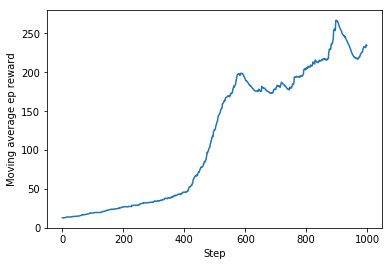

In [22]:
master = MasterAgent()
master.train()

After training, let's run `play()` to see how the model works.

In [23]:
if master is None:
  master = MasterAgent()
master.play()

Loading model from: /tmp/model_CartPole-v0.h5
0. Reward: 1.0, action: 0
1. Reward: 2.0, action: 1
2. Reward: 3.0, action: 0
3. Reward: 4.0, action: 1
4. Reward: 5.0, action: 0
5. Reward: 6.0, action: 1
6. Reward: 7.0, action: 0
7. Reward: 8.0, action: 1
8. Reward: 9.0, action: 0
9. Reward: 10.0, action: 1
10. Reward: 11.0, action: 0
11. Reward: 12.0, action: 1
12. Reward: 13.0, action: 0
13. Reward: 14.0, action: 1
14. Reward: 15.0, action: 0
15. Reward: 16.0, action: 1
16. Reward: 17.0, action: 0
17. Reward: 18.0, action: 1
18. Reward: 19.0, action: 0
19. Reward: 20.0, action: 1
20. Reward: 21.0, action: 0
21. Reward: 22.0, action: 1
22. Reward: 23.0, action: 0
23. Reward: 24.0, action: 1
24. Reward: 25.0, action: 0
25. Reward: 26.0, action: 1
26. Reward: 27.0, action: 0
27. Reward: 28.0, action: 0
28. Reward: 29.0, action: 1
29. Reward: 30.0, action: 0
30. Reward: 31.0, action: 1
31. Reward: 32.0, action: 0
32. Reward: 33.0, action: 1
33. Reward: 34.0, action: 0
34. Reward: 35.0, act